# Statistics

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set('notebook', 'white')

df_all_ = None
for result_file in glob('data/results/*.npy'):
    print(result_file)
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 2)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        result['relabeled'] = 'relabeled' in result_file
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            dataset_name = parts[3].split('.')[0]
            result['words'] = 'concepts'
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
        result['words'] = ['all' if x['preprocessing'] != None else 'only-nouns'  for x in result['params']]
        #result['words'] = result['params']['preprocessing']
    for param in result['params']:
        del param['clf']
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    if df_all_ is None:
        df_all_ = result_df
    else:
        df_all_ = df_all_.append(result_df)
#df_all['window_size'].fillna('concept-graph', inplace = True)

In [102]:
#df_all_[df_all_.dataset == 'ng20'].sort_values('mean_test_f1_macro', ascending = False)[['mean_test_f1_macro', 'type']]

,mean_test_f1_macro,type
3,0.807753,concept-graph
3,0.792472,concept-graph
3,0.764738,concept-graph
2,0.710519,concept-graph
2,0.704415,text
3,0.696837,cooccurrence
3,0.695664,cooccurrence
2,0.693733,concept-graph
3,0.693309,cooccurrence
3,0.693205,cooccurrence


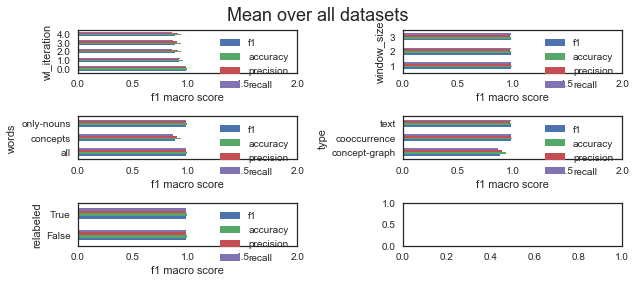

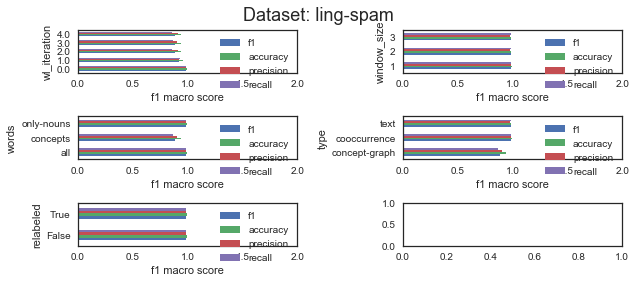

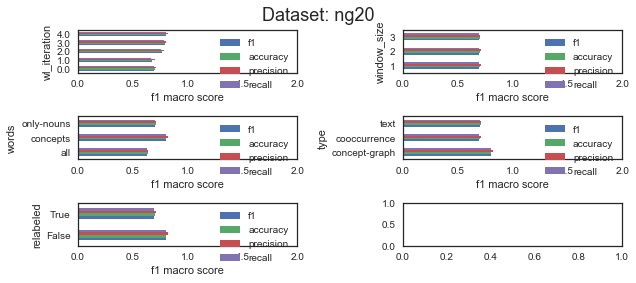

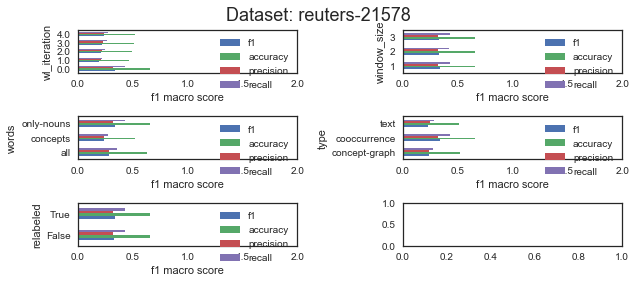

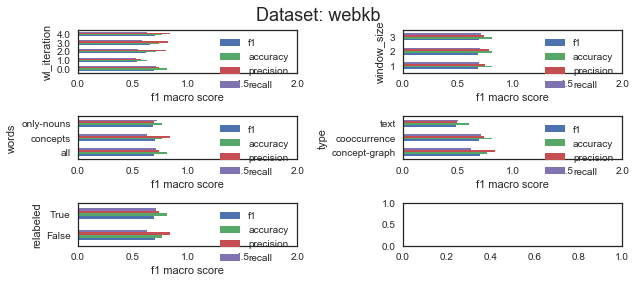

In [93]:
sns.set('notebook', 'white')
def plot_distributions(df, df_all, title = None, figsize = (9, 4)):
    fig, axes_indexed = plt.subplots(nrows = 3, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type', 'relabeled'], axes):
        if len(df.groupby(val).size()) == 0:
            continue
        grouped = df.groupby(val)
        els = df_all.iloc[grouped['mean_test_f1_macro'].idxmax()]
        els = els.set_index(val)
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim=(0, 2))
        #df.groupby(val).mean_test_f1_macro.mean().plot(kind = 'barh', ax = ax, xlim = (0, 1))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
dpi = 150
df_all = df_all_.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)
fig, _  = plot_distributions(df_all, df_all, title = 'Mean over all datasets')
fig.savefig('tmp/results/all.png', dpi = dpi)
plt.show()
plt.close(fig)
for name, df_dataset in df_all.groupby('dataset'):
    if len(df_dataset.type.value_counts()) < 3:
        continue
    fig, _ = plot_distributions(df_dataset, df_all, title = 'Dataset: {}'.format(name))
    fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = dpi)
    plt.show()
    plt.close(fig)


ling-spam
concept-graph       best f1-score: 0.8875	words: concepts      wl iteration: 3        relabeled: 0     
cooccurrence        best f1-score: 0.9857	words: all           wl iteration: 0        relabeled: 0     window_size: 1
text                best f1-score: 0.9832	words: only-nouns    stop words:   english


,dataset,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,mean_train_f1_macro,mean_train_precision_macro,...,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,ling-spam,0.233979,0.066834,0.943904,0.887459,0.906783,0.871036,1.000000,1.000000,1.000000,...,0.025680,0.031867,0.021916,0.000000,0.000000,0.000000,0.000000,NaN,3.0,concepts
cooccurrence,ling-spam,0.708045,0.094242,0.992050,0.985680,0.984545,0.986909,0.996543,0.993805,0.990994,...,0.003268,0.003181,0.006023,0.000978,0.001745,0.002865,0.000587,1,0.0,all
text,ling-spam,5.818120,8.345719,0.990667,0.983167,0.982022,0.984406,1.000000,1.000000,1.000000,...,0.005655,0.003203,0.008863,0.000000,0.000000,0.000000,0.000000,NaN,NaN,only-nouns


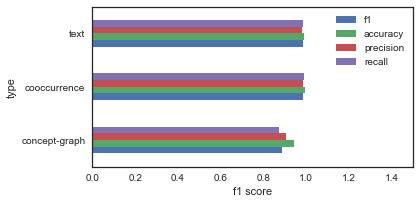

ng20
concept-graph       best f1-score: 0.8078	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.6968	words: only-nouns    wl iteration: 0        relabeled: 0     window_size: 2
text                best f1-score: 0.7044	words: only-nouns    stop words:   english


,dataset,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,mean_train_f1_macro,mean_train_precision_macro,...,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,ng20,8.949486,0.601977,0.807382,0.807753,0.821866,0.802511,0.999086,0.999040,0.999084,...,0.002433,0.002187,0.002885,0.000083,0.000080,0.000085,0.000096,NaN,4.0,concepts
cooccurrence,ng20,14.623144,0.876701,0.707312,0.696837,0.711719,0.695138,0.920010,0.922408,0.939818,...,0.002413,0.004072,0.001875,0.000653,0.000660,0.000373,0.000531,2,0.0,only-nouns
text,ng20,17.154864,24.695589,0.710973,0.704415,0.709949,0.702546,0.971055,0.974223,0.981514,...,0.001228,0.000488,0.001601,0.001210,0.000967,0.000532,0.001179,NaN,NaN,only-nouns


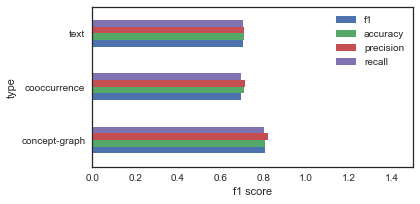

reuters-21578
concept-graph       best f1-score: 0.2363	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.3372	words: only-nouns    wl iteration: 0        relabeled: 1     window_size: 1
text                best f1-score: 0.2310	words: only-nouns    stop words:   english


,dataset,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,mean_train_f1_macro,mean_train_precision_macro,...,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,reuters-21578,16.433144,2.324164,0.522771,0.236335,0.238281,0.276940,0.844872,0.651695,0.603329,...,0.012657,0.007430,0.025994,0.002339,0.011308,0.013436,0.011733,NaN,4.0,concepts
cooccurrence,reuters-21578,17.271519,7.775020,0.661840,0.337170,0.319729,0.428530,0.757736,0.558642,0.523651,...,0.011456,0.013750,0.015253,0.003867,0.010423,0.013392,0.014249,1,0.0,only-nouns
text,reuters-21578,15.499870,13.008102,0.510579,0.230978,0.253778,0.288873,0.748033,0.541373,0.593160,...,0.014785,0.008559,0.020815,0.046848,0.033783,0.012526,0.037085,NaN,NaN,only-nouns


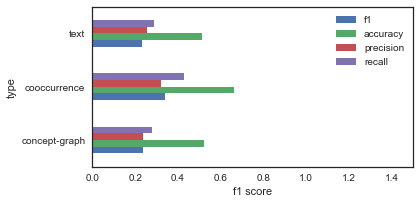

webkb
concept-graph       best f1-score: 0.7004	words: concepts      wl iteration: 4        relabeled: 0     
cooccurrence        best f1-score: 0.6958	words: all           wl iteration: 0        relabeled: 1     window_size: 3
text                best f1-score: 0.4895	words: only-nouns    stop words:   english


,dataset,mean_fit_time,mean_score_time,accuracy,f1,precision,recall,mean_train_accuracy,mean_train_f1_macro,mean_train_precision_macro,...,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_accuracy,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,webkb,3.043535,0.213261,0.764758,0.700402,0.838753,0.627124,0.997949,0.996418,0.994330,...,0.020121,0.012801,0.020433,0.000414,0.001112,0.002022,0.000298,NaN,4.0,concepts
cooccurrence,webkb,5.405627,0.574327,0.817380,0.695779,0.740574,0.714037,0.895999,0.819462,0.847696,...,0.014625,0.052854,0.015103,0.000972,0.010094,0.021275,0.015613,3,0.0,all
text,webkb,9.174963,16.743139,0.609258,0.489535,0.499145,0.502735,0.995227,0.991528,0.990354,...,0.009710,0.007909,0.016126,0.000983,0.004227,0.006483,0.002174,NaN,NaN,only-nouns


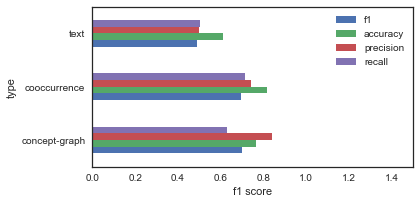

In [94]:
def plot_best_by_type(df_all, df, title = '', fontsize = 12, figsize = (6, 3), top = 0.85):
    fig, ax = plt.subplots(figsize = figsize)
    els = df_all.iloc[df['mean_test_f1_macro'].idxmax()]
    els = els.set_index('type')
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim = (0, 1.5))
    #    df['mean_test_f1_macro'].max().plot(kind = 'barh', ax = ax, xlim = (0, 1))#, xerr=els.std_test_f1_macro * 2)
    ax.set_xlabel('f1 score')
    for set_type, x in els.iterrows():
        out = '{:20}best f1-score: {x.f1:.4f}\twords: {x.words:14}'.format(set_type, x = x)
        if set_type != 'text':
            out += 'wl iteration: {x.wl_iteration:<8.0f} relabeled: {x.relabeled:<6}'.format(x = x)
        else:
            out += 'stop words:   {}'.format(x.params["count_vectorizer__stop_words"])
        if set_type == 'cooccurrence':
            out += 'window_size: {x.window_size}'.format(x = x)
        print(out)
    display(els)
    if title and title != '':
        fig.suptitle(title, fontsize = fontsize)
    fig.tight_layout()
    if title and title != '':
        fig.subplots_adjust(top = top)
    return fig, ax

for name, df_dataset in sorted(df_all.groupby('dataset'), key = lambda x: x[0]):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    print(name)
    use_title = False
    fig, ax = plot_best_by_type(df_all, df_dataset_grouped_by_type, 'Dataset: {}'.format(name) if use_title else None)
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 150)
    plt.show()
    plt.close(fig)


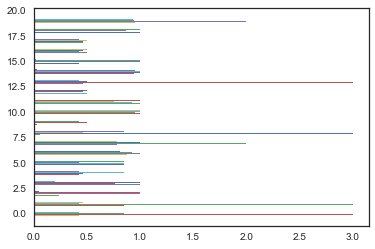

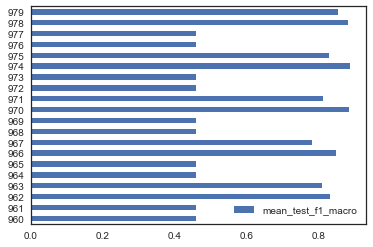

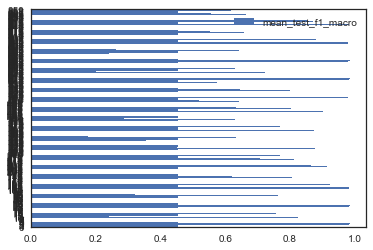

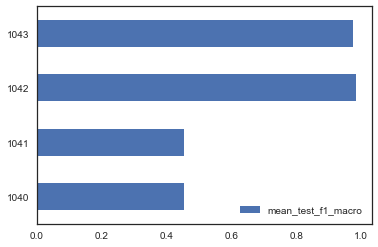

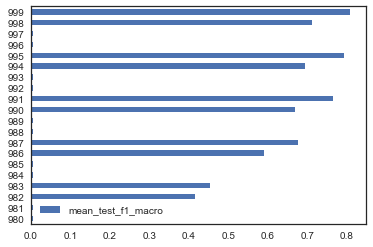

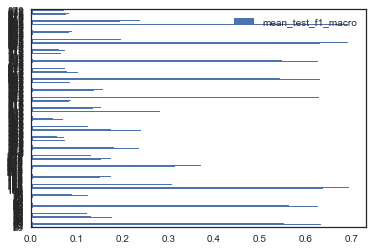

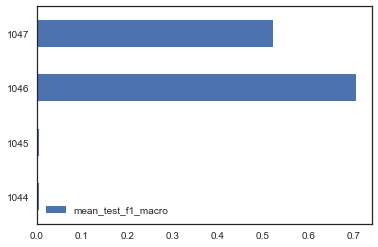

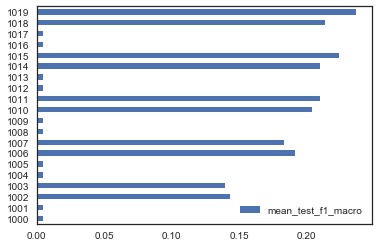

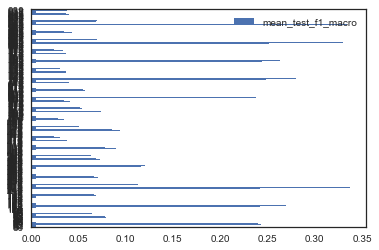

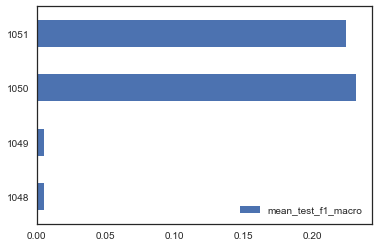

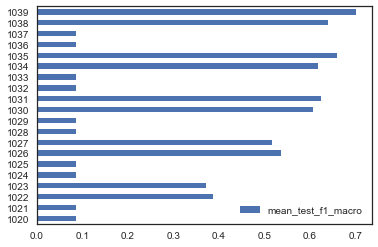

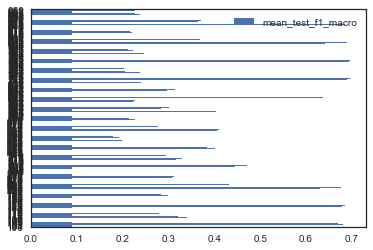

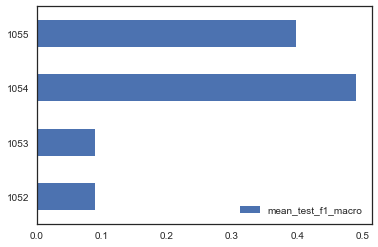

In [92]:
for name, df_dataset in sorted(df_all.groupby('dataset'), key = lambda x: x[0]):
    plt.show()

In [ ]:
df_by_ds = df_all[df_all.type != 'text'].groupby('dataset')

df_all.iloc[df_by_ds.mean_test_score.idxmax()]
df_all.columns

In [ ]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            if embedding == 'trained' and 'coo' in  dataset_file:
                print('Yes', counts['counts']['not_found'], not_found_ratio, '%', counts['not_found_sample'])
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][0][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df#[df.index == "ng20"]

In [ ]:
import dataset_helper
import matplotlib.pyplot as plt

currently = ['ling-spam', 'webkb', 'ng20', 'reuters-21578']

for dataset in dataset_helper.get_all_available_dataset_names():
    if dataset in currently: continue
    print(dataset)
    continue
    X, Y = dataset_helper.get_dataset(dataset)
    dataset_helper.plot_dataset_class_distribution(X, Y, 'Class distribution: {}'.format(dataset))
    plt.show()
    print('{}\n#Docs:\t{}\t# Classes:\t{}'.format(dataset, len(X), len(set(Y))))